Tratamento de dados discrepantes: remover ou isolar outliers dependendo do contexto (caso seja precise remover, utilize o pandas).


Tratamento de dados faltantes: Identificar e remover linhas/colunas com dados faltantes insignificantes. Imputar valores ausentes usando estatísticas de tendência central ou modelos preditivos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

In [2]:
tips = pd.read_csv('../data/raw/tips.csv')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [3]:
tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


# Tratando outliers

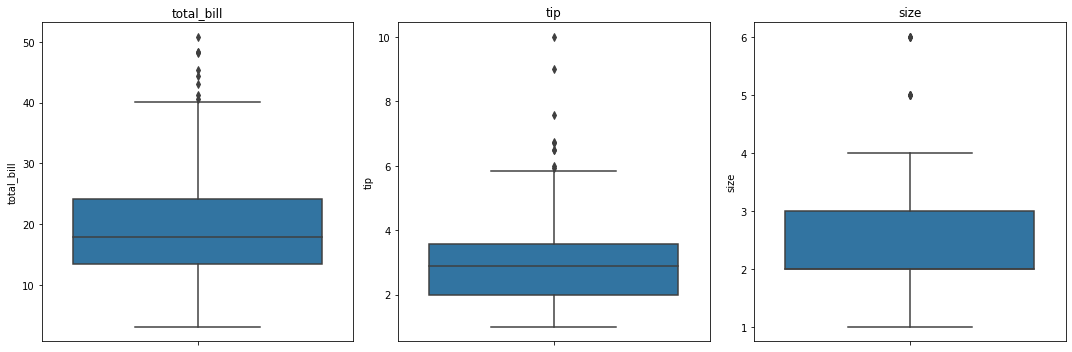

In [16]:
numeric_columns = tips.select_dtypes(include = ['float64', 'int64'])

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, column in enumerate(numeric_columns):

    sns.boxplot(y=tips[column], ax=axs[i])
    axs[i].set_title(f'{column}')


plt.tight_layout()

plt.show()

Podemos ver que todas as colunas têm outliers.


Para resolver isso vamos utilizar o método do IQR, basicamente calculando os limites inferior e superior usando o intervalo inter quartil.

In [6]:
def remove_outliers_iqr(df):
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [8]:
tips_no_outliers = remove_outliers_iqr(tips)


tips_no_outliers.shape

(222, 7)

Antes da remoção de outliers tínhamos 244 instâncias e após a remoção temos 222, logo foram removidos 22 valores considerados outliers.

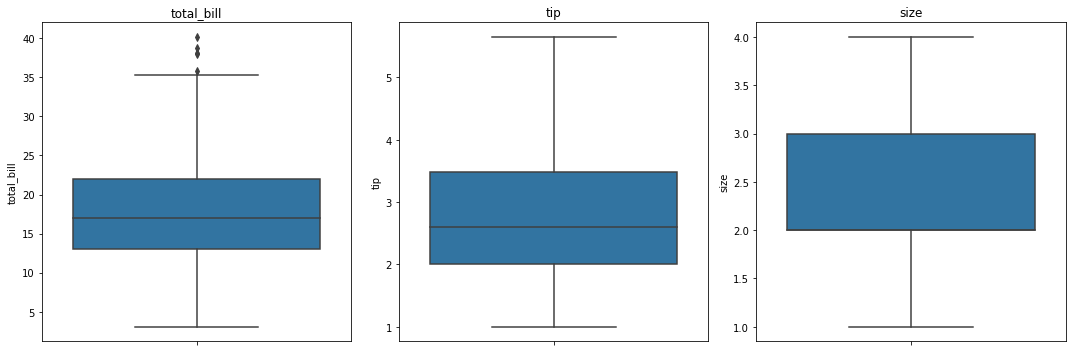

In [15]:
numeric_columns = tips_no_outliers.select_dtypes(include = ['float64', 'int64'])

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, column in enumerate(numeric_columns):

    sns.boxplot(y=tips_no_outliers[column], ax=axs[i])
    axs[i].set_title(f'{column}')


plt.tight_layout()

plt.show()

# Tratamento de dados faltantes

In [4]:
tips.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

Não será necessário remover ou substituir os valores